In [3]:
import os
import torch
print(torch.__version__)
import numpy as np
print(np.__version__)
import snntorch as snn
print(snn.__version__)
import snntorch.functional as SF
from snntorch import surrogate
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
print(torchvision.__version__)
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)
import PIL
from PIL import Image
print(PIL.__version__)


2.5.0+cu118
1.26.4
0.9.1
0.20.0+cpu
3.9.2
10.4.0


In [20]:
# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [21]:
# Data Preprocessing with more augmentation
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [22]:
# Load Data
train_data_path = 'archive\\Animal Image Dataset'
full_dataset = ImageFolder(root=train_data_path, transform=data_transform)

# Split Dataset into Training and Testing (80-20 split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


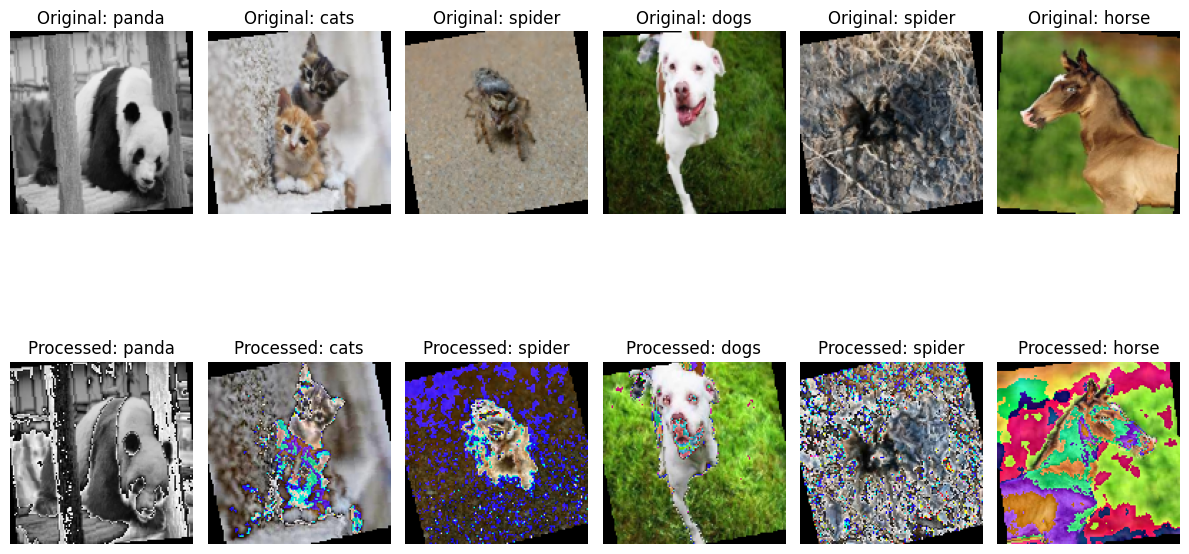

In [23]:
# Function to show images
def show_images(original_images, processed_images, labels, label_map, num_images=6):
    """Display a grid of original and processed images side by side."""
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        # Original Images
        plt.subplot(2, num_images, i + 1)
        img = original_images[i].numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.imshow(img)
        plt.title(f"Original: {label_map[labels[i].item()]}")
        plt.axis('off')

        # Processed Images
        plt.subplot(2, num_images, i + 1 + num_images)
        img = processed_images[i].numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.imshow(img)
        plt.title(f"Processed: {label_map[labels[i].item()]}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Load a sample batch of original images without transformations
sample_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)  # Load a sample batch
original_images, labels = next(iter(sample_loader))  # Get a batch of images and labels

# Convert original images from tensors to PIL images for processing
original_images_pil = [transforms.ToPILImage()(img) for img in original_images]

# Apply transformations to get processed images
processed_images = [data_transform(img) for img in original_images_pil]  # Transform each original image

# Create a label map
label_map = {v: k for k, v in full_dataset.class_to_idx.items()}  # Create a label map

# Show the original and processed images
show_images(original_images, processed_images, labels, label_map)  # Show the images


In [ ]:
class SNNModel(nn.Module):
    def __init__(self):
        super(SNNModel, self).__init__()
        
        # Convolutional Layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lif1 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())
        self.dropout1 = nn.Dropout(p=0.5)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lif2 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())
        self.dropout2 = nn.Dropout(p=0.5)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 45 * 45, 128)
        self.lif_fc1 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())
        self.dropout_fc1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, len(full_dataset.classes))

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_fc1 = self.lif_fc1.init_leaky()

        # Layer 1
        x = self.conv1(x)
        x = self.bn1(x)  # Apply batch normalization
        x = self.pool1(x)
        x, mem1 = self.lif1(x, mem1)
        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)  # Apply batch normalization
        x = self.pool2(x)
        x, mem2 = self.lif2(x, mem2)
        x = self.dropout2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = self.fc1(x)
        x, mem_fc1 = self.lif_fc1(x, mem_fc1)
        x = self.dropout_fc1(x)
        x = self.fc2(x)

        return x


In [25]:
# Initialize and move model to device
snn_model = SNNModel().to(device)


In [26]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(snn_model.parameters(), lr=1e-4)


In [27]:
# Training Loop for SNN
# train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)  # Define train_loader

num_epochs = 60
snn_train_losses = []
snn_test_losses = []
snn_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training Phase
    snn_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = snn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    snn_train_loss = running_loss / len(train_loader)
    snn_accuracy = 100 * correct / total
    snn_train_losses.append(snn_train_loss)
    snn_accuracies.append(snn_accuracy)

    # Testing Phase
    snn_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = snn_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    snn_test_loss = test_loss / len(test_loader)
    snn_test_losses.append(snn_test_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {snn_train_loss:.4f}, Test Loss: {snn_test_loss:.4f}, Accuracy: {snn_accuracy:.2f}%")

print("SNN training complete.")


Epoch [1/60], Train Loss: 2.5401, Test Loss: 2.4562, Accuracy: 8.39%
Epoch [2/60], Train Loss: 2.5169, Test Loss: 2.4490, Accuracy: 9.24%
Epoch [3/60], Train Loss: 2.4940, Test Loss: 2.4095, Accuracy: 10.14%
Epoch [4/60], Train Loss: 2.4442, Test Loss: 2.3643, Accuracy: 12.92%
Epoch [5/60], Train Loss: 2.3980, Test Loss: 2.3246, Accuracy: 14.69%
Epoch [6/60], Train Loss: 2.3651, Test Loss: 2.2951, Accuracy: 17.21%
Epoch [7/60], Train Loss: 2.3421, Test Loss: 2.2712, Accuracy: 18.42%
Epoch [8/60], Train Loss: 2.3164, Test Loss: 2.2453, Accuracy: 20.01%
Epoch [9/60], Train Loss: 2.2931, Test Loss: 2.2247, Accuracy: 20.11%
Epoch [10/60], Train Loss: 2.2582, Test Loss: 2.1913, Accuracy: 22.08%
Epoch [11/60], Train Loss: 2.2360, Test Loss: 2.1558, Accuracy: 23.30%
Epoch [12/60], Train Loss: 2.2021, Test Loss: 2.1260, Accuracy: 24.76%
Epoch [13/60], Train Loss: 2.1824, Test Loss: 2.1099, Accuracy: 25.72%
Epoch [14/60], Train Loss: 2.1661, Test Loss: 2.0913, Accuracy: 26.02%
Epoch [15/60], Tr

OSError: Caught OSError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\_utils\fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\datasets\folder.py", line 245, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\datasets\folder.py", line 284, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\datasets\folder.py", line 264, in pil_loader
    return img.convert("RGB")
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\PIL\Image.py", line 995, in convert
    self.load()
  File "C:\Users\psono\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\PIL\ImageFile.py", line 312, in load
    raise _get_oserror(err_code, encoder=False)
OSError: broken data stream when reading image file


In [ ]:
# num_epochs = 50  # Define the number of epochs
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)  # Define train_loader

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     # Training loop over batches
#     for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()  # Zero gradients

#         # Forward pass
#         outputs = snn_model(images)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Update running loss and calculate accuracy
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # Print loss every 100 batches
#         if (i + 1) % 100 == 0:
#             print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
#             running_loss = 0.0

#     # Print accuracy for each epoch
#     accuracy = 100 * correct / total
#     print(f"Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {accuracy:.2f}%")

# print("Training complete.")


In [ ]:
# Save the model
torch.save(snn_model.state_dict(), 'snn_model2.pth')
print("Model saved as snn_model.pth")

Model saved as snn_model.pth


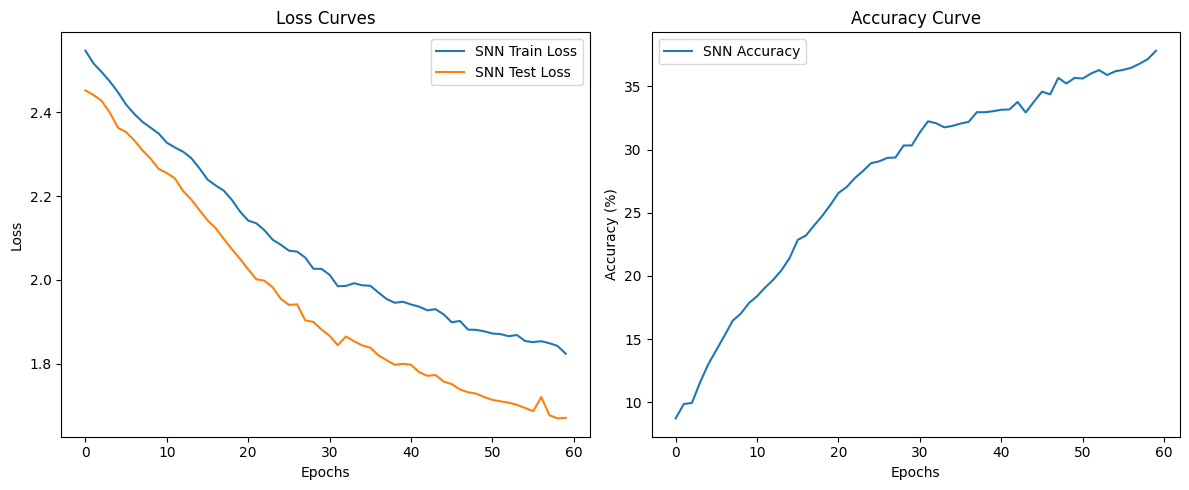

In [ ]:
# Plotting Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(snn_train_losses, label='SNN Train Loss')
plt.plot(snn_test_losses, label='SNN Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(snn_accuracies, label='SNN Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing Accuracy Calculation
snn_model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print(f'actual lebel:{labels} predicated lebel : {predicted}')

# Print Testing Accuracy
test_accuracy = 100 * correct / total
print(f'Testing Accuracy: {test_accuracy:.2f}%')

Testing Accuracy: 43.34%


In [ ]:
# Prediction function for animal detection
from PIL import Image
def predict(image_path, model, label_map, data_transform):
    model.eval()  # Set the model to evaluation mode
    img = Image.open(image_path).convert("RGB")  # Open the image and convert to RGB if needed
    img = data_transform(img)  # Apply transformations to match model input size and format
    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    with torch.no_grad():  # No gradient calculation, to speed up inference
        output = model(img)  # Get model predictions
        _, predicted = torch.max(output, 1)  # Get the index of the max probability
        class_name = label_map[predicted.item()]  # Convert the predicted index to class name
        return class_name  # Return the predicted class name


In [ ]:
# Load and predict with the trained model
label_map = {v: k for k, v in full_dataset.class_to_idx.items()}

image_path = 'test/horse2.jpeg'
predicted_label = predict(image_path, snn_model, label_map,data_transform)
print(f"Predicted Label: {predicted_label}")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\psono\\Downloads\\major_project\\test\\horse2.jpeg'

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Load the model architecture
snn_model = SNNModel().to(device)

# Load the saved weights
snn_model.load_state_dict(torch.load('snn_model2.pth', map_location=device))

# Set the model to evaluation mode (disables training-specific layers like dropout)
snn_model.eval()

# Example prediction function using the loaded model
def predict(image_path, model, label_map):
    img = Image.open(image_path).convert("RGB")
    img = data_transform(img).unsqueeze(0).to(device)  # Preprocess and add batch dimension
    
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        return label_map[predicted.item()]

# Predict on a new image
image_path = 'archive/Animal Image Dataset/hen/4.jpeg'  # Specify your test image path
predicted_label = predict(image_path, snn_model, label_map)
print(f"Predicted Label: {predicted_label}")


C:\Users\psono\AppData\Local\Temp\ipykernel_24968\1419636218.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snn_model.load_state_dict(torch.load('snn_model2.pth', map_

Predicted Label: hen
